# 1. Setup e Imports

In [84]:
# - Local (VS Code): instalar deps con pip install -r requirements.txt y correr directo.
# - Colab: esta celda instala solo lo necesario, sin desinstalar nada.

import sys
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB:
    %pip -q install --upgrade --force-reinstall "numpy==1.26.4"
    %pip -q install "pandas>=1.5,<2.3" "matplotlib>=3.7,<3.9" "seaborn>=0.12" "scipy>=1.10,<1.14" "fitter==1.7.1"

# Imports
import os
from pathlib import Path
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from fitter import Fitter
from dataclasses import dataclass
from typing import Optional

# Estilo / reproducibilidad / display
sns.set(style="whitegrid")
np.random.seed(42)
random.seed(42)
pd.set_option("display.width", 120)
pd.set_option("display.max_columns", 50)

# (Opcional) mostrar versiones en Colab
if IN_COLAB:
    import importlib
    for m in ("numpy","pandas","matplotlib","seaborn","scipy","fitter"):
        mod = importlib.import_module(m)
        print(f"{m:>10}: {getattr(mod,'_version_','?')}")

# Placeholders globales para los samplers/ajustes (se completan en ajustar_fdps_desde_df)
gen_TS_dataset = None
gen_LLIN_dataset = None
best_ts_dataset = {}
best_llin_dataset = {}

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tsfresh 0.21.1 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.13.1 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
     numpy: ?
    pandas: ?
matplotlib: ?
   seaborn: ?
     scipy: ?
    fitter: ?


In [85]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 2. Ingesta Dataset externo

In [86]:
# Carpeta de inputs (Colab vs local)
DATA_DIR = Path("/content/inputs") if IN_COLAB else (Path.cwd() / "inputs")
DATA_DIR.mkdir(parents=True, exist_ok=True)

SCENARIO_CSV = DATA_DIR / "blockchain_real_state_data_2021_2022_full.csv"  # <- cambiar si es otro nombre de archivo

if not SCENARIO_CSV.exists():
    raise FileNotFoundError(
        f"No encuentro el archivo de escenarios: {SCENARIO_CSV}\n"
        f"Colocalo en {DATA_DIR} o cambiá el nombre arriba."
    )

df_scenarios = pd.read_csv(SCENARIO_CSV)
print("✅ Escenarios cargados:", df_scenarios.shape)
print("▶ Ruta:", SCENARIO_CSV)
print("▶ Columnas:", list(df_scenarios.columns))

# Unidad de tiempo de toda la sim
TIME_UNIT = "horas"

✅ Escenarios cargados: (54000, 7)
▶ Ruta: /content/inputs/blockchain_real_state_data_2021_2022_full.csv
▶ Columnas: ['requested_tokenization_delay_min', 'requested_mint_time', 'potential_buyer_arrival_delay_time', 'potential_buyer_buy_time', 'mint_delay_min', 'burn_token_time', 'price_update_time']


# 3. Simulación por escenario

In [87]:

from dataclasses import dataclass
from typing import Optional, Callable

@dataclass
class SimResult:
    df_eventos: pd.DataFrame
    metrics: dict
    saldos_compradores: list

def simular_escenario(
    row: pd.Series,
    out_dir: Optional[Path] = None,
    save_files: bool = False,
    *,
    # --- NUEVO: overrides opcionales ---
    GAS_override: Optional[float] = None,
    VALOR_VENTA_TOKEN: Optional[float] = None,
    VALOR_VENTA_TOKEN_NUEVO: Optional[float] = None,
    P_UPDATE_override: Optional[float] = None,
    seed_override: Optional[int] = None
) -> SimResult:
    if save_files and out_dir is not None:
        out_dir.mkdir(parents=True, exist_ok=True)

    # --- Parámetros desde dataset, con override ---
    N_EVENTOS = int(row.get("n_eventos", 1000))

    GAS = float(row.get("gas_fee_usd", 30.0)) if GAS_override is None else float(GAS_override)

    PARTES_MAX = int(row.get("partes_de_prop", 1000))
    MEAN_TS = max(1e-6, float(row.get("mint_delay_min", 20.0)) / 60.0)  # min → h
    MEAN_LLIN = max(1e-6, float(row.get("potential_buyer_arrival_delay_time", 30.0)))  # h
    MEAN_SEC = max(1e-6, float(row.get("time_to_price_update_days", 3.0)) * 24.0)  # días → h

    P_KYC = float(row.get("kyc_pass", 0.5))
    P_BURN = float(row.get("burn_prob", 0.05))

    # --- Normalizar P_UPDATE ---
    p_update_raw = float(row.get("price_update_prob", 20.0)) if P_UPDATE_override is None else float(P_UPDATE_override)
    P_UPDATE = p_update_raw/100.0 if p_update_raw > 1 else p_update_raw
    P_UPDATE = min(max(P_UPDATE, 0.0), 1.0 - P_BURN)  # [0, 1 - P_BURN]

    TOKEN_PRICE = float(row.get("token_price_usd", 20000.0)) if VALOR_VENTA_TOKEN is None else float(VALOR_VENTA_TOKEN)

    BUYER_BUDG = float(row.get("buyer_budget_usd", 3000.0))
    PRICE_SD = max(1.0, 0.10 * TOKEN_PRICE)
    BUDG_SD = max(1.0, 0.15 * BUYER_BUDG)

    # --- Semillas ---
    if seed_override is not None:
        np.random.seed(int(seed_override)); random.seed(int(seed_override))
    elif "seed" in row and not pd.isna(row["seed"]):
        seed = int(row["seed"]); np.random.seed(seed); random.seed(seed)
    # (Si no hay override ni seed en el CSV, no tocamos la semilla)

    partes_de_prop = PARTES_MAX
    tokens_vend = []
    saldo_vend = 5000.0
    eventos = []
    tiempo = 0.0
    CTS = 0; CTF = 0; tokens_emitidos = 0; tokens_burneados = 0; saldos_compradores = []

    # Samplers (dataset fits o exponenciales)
    _gen_ts_candidate = globals().get('gen_TS_dataset', None)
    _gen_llin_candidate = globals().get('gen_LLIN_dataset', None)
    gen_TS  = _gen_ts_candidate
    gen_LLIN= _gen_llin_candidate
    gen_SEC = lambda: np.random.exponential(scale=MEAN_SEC)

    def _wrap_pos(fn: Callable[[], float]):
        def _inner():
            x = float(fn())
            return 1e-9 if (not np.isfinite(x) or x <= 0.0) else x
        return _inner
    gen_TS = _wrap_pos(gen_TS); gen_LLIN = _wrap_pos(gen_LLIN); gen_SEC = _wrap_pos(gen_SEC)

    # --- Opcional: función para "nuevo" precio de venta ---
    def precio_actualizado(precio_base: float) -> float:
        if VALOR_VENTA_TOKEN_NUEVO is not None:
            return float(VALOR_VENTA_TOKEN_NUEVO)
        # Si no pasaste “nuevo” precio, mantené base (o podés meter ruido):
        # return max(10.0, float(np.random.normal(precio_base, PRICE_SD)))
        return precio_base

    # --- Bucle principal ---
    for _ in range(N_EVENTOS):
        r = random.random()
        if r < 0.35:
            # MINT
            tiempo += gen_TS()
            if (tokens_emitidos < partes_de_prop) and (saldo_vend >= GAS):
                CTS += 1; saldo_vend -= GAS
                token_id = f"T{tokens_emitidos}"
                tokens_vend.append({"id": token_id, "precio": TOKEN_PRICE})
                tokens_emitidos += 1
                eventos.append([tiempo, "mint", token_id, saldo_vend, None])

        elif r < 0.7:
            # COMPRA
            tiempo += gen_LLIN()
            if random.random() < P_KYC:
                saldo_comprador = max(0.0, float(np.random.normal(BUYER_BUDG, BUDG_SD)))
                if tokens_vend:
                    token = random.choice(tokens_vend); precio = token["precio"]
                    if saldo_comprador >= precio:
                        saldo_comprador -= precio; saldo_vend += precio
                        tokens_vend.remove(token); saldos_compradores.append(saldo_comprador)
                        eventos.append([tiempo, "compra_exitosa", token["id"], saldo_vend, saldo_comprador])
                    else:
                        CTF += 1; eventos.append([tiempo, "compra_fallida_fondos", token["id"], saldo_vend, saldo_comprador])
                else:
                    CTF += 1; eventos.append([tiempo, "compra_fallida_sin_tokens", None, saldo_vend, saldo_comprador])

        else:
            # SEC: burn o actualización de precio
            tiempo += gen_SEC()
            if tokens_vend:
                token = random.choice(tokens_vend); rr = random.random()
                if rr < P_BURN:
                    tokens_vend.remove(token); tokens_burneados += 1
                    eventos.append([tiempo, "burn_token", token["id"], saldo_vend, None])
                elif rr < (P_BURN + P_UPDATE):
                    # --- FIX: usar VALOR_VENTA_TOKEN_NUEVO si lo pasaste ---
                    token["precio"] = precio_actualizado(TOKEN_PRICE)
                    eventos.append([tiempo, "actualizacion_precio", token["id"], saldo_vend, token["precio"]])

    # --- Cierre y return (faltaba en tu archivo compartido) ---
    df_eventos = pd.DataFrame(eventos, columns=["tiempo","evento","token","saldo_vendedor","extra"])
    metrics = {
        "CTS": CTS,
        "CTF": CTF,
        "tokens_emitidos": tokens_emitidos,
        "tokens_burneados": tokens_burneados,
        "PSC": float(np.mean(saldos_compradores)) if len(saldos_compradores) else 0.0,
    }
    return SimResult(df_eventos=df_eventos, metrics=metrics, saldos_compradores=saldos_compradores)


# 4. Helper

In [88]:
from fitter import Fitter
from scipy import stats

def ajustar_fdps_desde_df(df, time_unit="horas", topN_plots: int | None = None,
                          out_dir="outputs"):

    os.makedirs(out_dir, exist_ok=True)

    # Series crudas (del dataset), convertidas a HORAS y > 0
    ts_hours   = pd.to_numeric(df["mint_delay_min"], errors="coerce").dropna() / 60.0
    llin_hours = pd.to_numeric(df["potential_buyer_arrival_delay_time"], errors="coerce").dropna()
    ts_hours   = ts_hours[ts_hours > 0]
    llin_hours = llin_hours[llin_hours > 0]

    # Ajuste completo (todas las distribuciones disponibles en fitter)
    f_ts   = None
    f_llin = None
    best_ts_dataset   = {}
    best_llin_dataset = {}

    if len(ts_hours) >= 3:
        f_ts = Fitter(ts_hours)          # TODAS las dists
        f_ts.fit()
        best_ts_dataset = f_ts.get_best(method="sumsquare_error")  # {'dist': {params}}

    if len(llin_hours) >= 3:
        f_llin = Fitter(llin_hours)
        f_llin.fit()
        best_llin_dataset = f_llin.get_best(method="sumsquare_error")

    # Samplers a partir del best (si existiera)
    def _make_sampler(best):
        if not best:
            return None
        name, params = list(best.items())[0]
        # Usamos 'freezing' de scipy.stats con kwargs (shape(s), loc, scale)
        try:
            rv = getattr(stats, name)(**params)
            return lambda: float(rv.rvs(size=1)[0])
        except Exception:
            # Fallback: rvs con kwargs directos
            return lambda: float(getattr(stats, name).rvs(size=1, **params)[0])

    gen_TS_dataset   = _make_sampler(best_ts_dataset)
    gen_LLIN_dataset = _make_sampler(best_llin_dataset)

    # Guardado de resumen del ajuste desde dataset (idempotente)
    rows_ds = []
    def _row_ds(nombre, best, serie):
        if not best:
            return {"variable": nombre, "mejor_dist": "sin_ajuste", "params_json": "{}", "n": int(len(serie)), "unidad_tiempo": time_unit}
        dist, params = list(best.items())[0]
        return {"variable": nombre, "mejor_dist": dist, "params_json": json.dumps(params), "n": int(len(serie)), "unidad_tiempo": time_unit}

    rows_ds.append(_row_ds("TS",   best_ts_dataset,   ts_hours))
    rows_ds.append(_row_ds("LLIN", best_llin_dataset, llin_hours))
    pd.DataFrame(rows_ds).to_csv(os.path.join(out_dir, "ajustes_fdp_dataset.csv"), index=False)
    with open(os.path.join(out_dir, "ajustes_fdp_dataset.json"), "w", encoding="utf-8") as f:
        json.dump(rows_ds, f, ensure_ascii=False, indent=2)

    # ---------- Gráficas Top-N superpuestas (opcional) ----------
    if isinstance(topN_plots, int) and topN_plots > 0:
        def _get_topN_names(f: Fitter, N: int):
            # Intentar obtener ranking desde atributos internos / summary
            try:
                # 1) Si existe dict de SSE
                errs = getattr(f, "sumsquare_error", None) or getattr(f, "sum_square_error", None)
                if errs:
                    return [k for k, _ in sorted(errs.items(), key=lambda kv: kv[1])[:N]]
            except Exception:
                pass
            try:
                # 2) Probar con summary que devuelva DF
                df_sum = f.summary(N)
                if df_sum is not None and hasattr(df_sum, "index"):
                    return list(df_sum.index[:N])
            except Exception:
                pass
            try:
                # 3) Último recurso: primeros N con parámetros ajustados
                names = list(getattr(f, "fitted_param", {}).keys())
                return names[:N]
            except Exception:
                return []

        def _plot_topN_overlay(serie, f: Fitter, var_name: str, topN: int, path_png: str):
            s = np.asarray(serie, dtype=float)
            s = s[np.isfinite(s) & (s > 0)]
            if len(s) < 3 or f is None:
                print(f"⚠️ {var_name}: sin datos suficientes para graficar Top-{topN}.")
                return
            names = _get_topN_names(f, topN)
            if not names:
                print(f"⚠️ {var_name}: no se obtuvo ranking de distribuciones.")
                return

            x = np.linspace(s.min(), s.max(), 400)
            plt.figure(figsize=(9, 5))
            # Histograma normalizado
            plt.hist(s, bins=50, density=True, alpha=0.25, label="Datos")
            # Superposición de PDFs
            for name in names:
                params = None
                # Fitter suele guardar en 'fitted_param'
                fp = getattr(f, "fitted_param", None) or {}
                params = fp.get(name)
                if params is None:
                    continue
                try:
                    rv = getattr(stats, name)(**params)
                    y = rv.pdf(x)
                    plt.plot(x, y, label=name)
                except Exception:
                    # Si algo falla con esa dist, la saltamos
                    continue

            plt.title(f"{var_name} — Top {len(names)} FDPs (pdf)")
            plt.xlabel(f"Δ tiempo ({time_unit})")
            plt.ylabel("Densidad")
            plt.legend()
            plt.tight_layout()
            plt.savefig(path_png, dpi=150)
            plt.show()
            print(f"🖼️ Guardado: {path_png}")

        # Hacer las dos figuras
        _plot_topN_overlay(ts_hours,   f_ts,   "TS",   topN_plots, os.path.join(out_dir, f"fdp_ts_top{topN_plots}_overlay.png"))
        _plot_topN_overlay(llin_hours, f_llin, "LLIN", topN_plots, os.path.join(out_dir, f"fdp_llin_top{topN_plots}_overlay.png"))

    return best_ts_dataset, best_llin_dataset, gen_TS_dataset, gen_LLIN_dataset, f_ts, f_llin

# Flags + Helpers - All scenarios

In [89]:
SAVE_EVENTS_ALL    = False   # ← para 54k escenarios: dejarlo en False
EVENTS_SAMPLE_PCT  = 0.00    # p.ej. 0.01 = 1% de eventos por escenario
EVENTS_GZIP        = True    # comprimir eventos si se guardan
EVENTS_SHARD_SIZE  = 500     # escenarios por archivo; 0 o None = un solo archivo
EVENTS_BASENAME    = "eventos_all"  # prefijo de shards

SAVE_METRICAS_ALL  = True    # métricas son livianas → guardarlas siempre

from pathlib import Path

def _events_path_for_shard(base_out: Path, shard_idx: int, gzip: bool) -> Path:
    suf = f"_s{shard_idx:03d}.csv" + (".gz" if gzip else "")
    return base_out / f"{EVENTS_BASENAME}{suf}"

def _append_events(df: pd.DataFrame, scenario_name: str,
                   base_out: Path, shard_idx: int, gzip: bool):
    """Append de eventos (opcionalmente sampleados) en CSV(.gz) por shard."""
    if df is None or df.empty:
        return
    path = _events_path_for_shard(base_out, shard_idx, gzip)
    header = not path.exists()
    df.assign(scenario=scenario_name).to_csv(
        path, mode="a", header=header, index=False,
        compression=("gzip" if gzip else None)
    )
    return path

def _append_metricas(row_dict: dict, base_out: Path):
    """Append de métricas por escenario a un único CSV."""
    path = base_out / "metricas_all.csv"
    header = not path.exists()
    pd.DataFrame([row_dict]).to_csv(path, mode="a", header=header, index=False)
    return path

# 5. Driver

▶ Base: idx=0  scenario=idx_0
📁 Guardado:
 - outputs/ctrl3/metricas_3esc.csv
 - outputs/ctrl3/eventos_3esc.csv


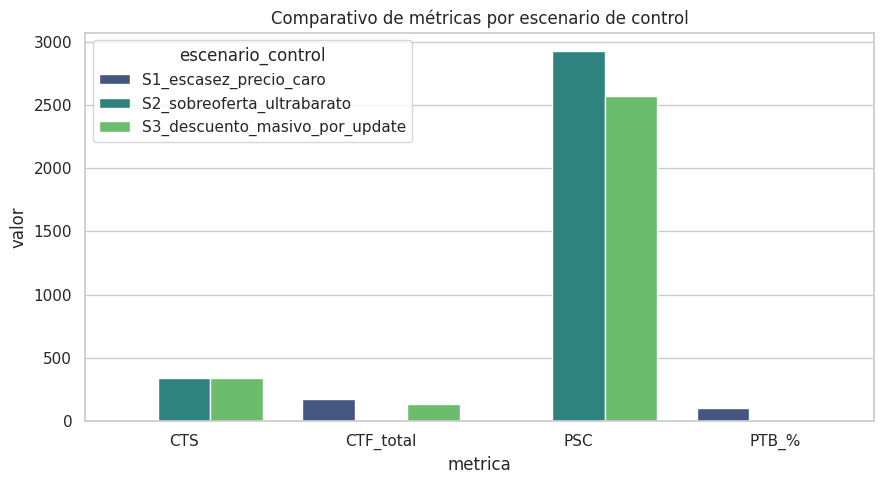

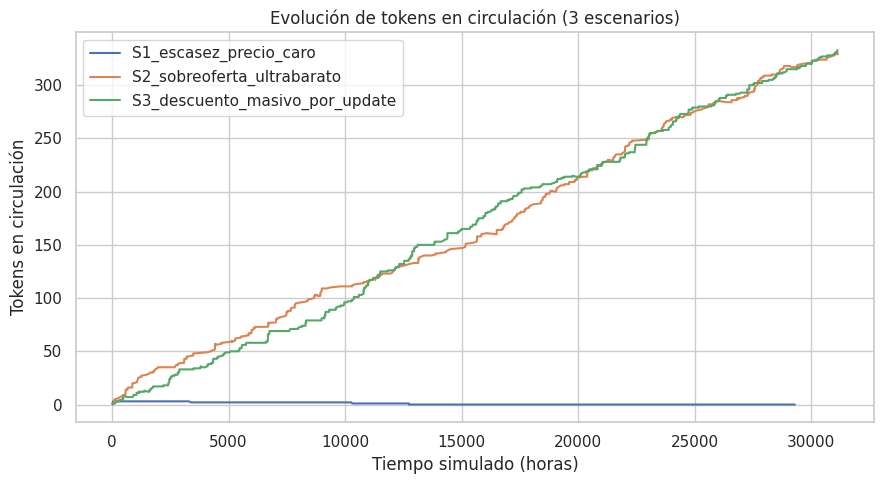

In [90]:
# ===== NUEVO: Driver 3 escenarios de control =====
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

BASE_OUT = Path("outputs")
CTRL_OUT = BASE_OUT / "ctrl3"
CTRL_OUT.mkdir(parents=True, exist_ok=True)

# Elegí la fila base del CSV
SCENARIO_NAME = None   # si sabés el nombre exacto; p.ej. "escenario_00042"
SCENARIO_IDX  = 0      # si no hay nombre, usa índice

if SCENARIO_NAME is not None:
    mask = (df_scenarios["scenario"].astype(str).str.strip() == str(SCENARIO_NAME).strip())
    assert mask.any(), f"No encontré scenario == {SCENARIO_NAME!r}"
    base_row = df_scenarios[mask].iloc[0]
    base_idx = int(base_row.name)
else:
    base_idx = int(SCENARIO_IDX)
    base_row = df_scenarios.iloc[base_idx]

print(f"▶ Base: idx={base_idx}  scenario={str(base_row.get('scenario', f'idx_{base_idx}'))}")


from scipy import stats

TS_PARAMS   = {"c": 1.8628396677686365, "loc": 0.016666665752324165, "scale":  0.16887239768297052}       # foldnorm
LLIN_PARAMS = {"a": 1.8929395194400112, "b": 648609.8369038888, "loc": 0.4483324231763361, "scale": 10124340.571899358}  # beta

gen_TS_dataset   = (lambda rv=stats.foldnorm(**TS_PARAMS): (lambda: float(rv.rvs(1)[0])))()
gen_LLIN_dataset = (lambda rv=stats.beta(**LLIN_PARAMS):   (lambda: float(rv.rvs(1)[0])))()

globals()['gen_TS_dataset']   = gen_TS_dataset
globals()['gen_LLIN_dataset'] = gen_LLIN_dataset
globals()['best_ts_dataset']  = {"foldnorm": TS_PARAMS}
globals()['best_llin_dataset'] = {"beta": LLIN_PARAMS}


# --- Definí acá tus 3 escenarios de control (EDITÁ valores) ---
SCENARIOS_CTRL = [
    # 1) ESCASEZ EXTREMA + PRECIO CARO
    #    - GAS altísimo => casi no se puede mintear (saldo_vendedor = 5000 → ~3 mints).
    #    - Precio inicial y actualizado muy caros => casi 0 compras.
    #    - P_UPDATE alto => casi todos los SEC con tokens terminan en actualizacion_precio.
    {
        "name": "S1_escasez_precio_caro",
        "GAS": 1500.0,
        "VALOR_VENTA_TOKEN": 30000.0,
        "VALOR_VENTA_TOKEN_NUEVO": 35000.0,
        "P_UPDATE": 0.60,   # 60%
        "SEED": None
    },

    # 2) SOBREOFERTA + ULTRA BARATO (precio plano)
    #    - GAS bajísimo => se pueden mintear muchos tokens (limitado por PARTES_MAX / eventos).
    #    - Precio regalado => muchísimas compras exitosas.
    #    - P_UPDATE = 0 => no hay cambios de precio (línea base para comparar).
    {
        "name": "S2_sobreoferta_ultrabarato",
        "GAS": 1.0,
        "VALOR_VENTA_TOKEN": 25.0,
        "VALOR_VENTA_TOKEN_NUEVO": 25.0,
        "P_UPDATE": 0.00,   # 0%
        "SEED": None
    },

    # 3) DESCUENTO MASIVO POR UPDATE
    #    - GAS medio => se mintean ~100 tokens (5000 / 50) si hay suficientes eventos.
    #    - Precio inicial muy alto => casi no se compra al principio.
    #    - P_UPDATE altísimo + precio nuevo muy bajo => tras las updates empiezan a llover compras.
    {
        "name": "S3_descuento_masivo_por_update",
        "GAS": 50.0,
        "VALOR_VENTA_TOKEN": 15000.0,
        "VALOR_VENTA_TOKEN_NUEVO": 500.0,
        "P_UPDATE": 0.90,   # 90%
        "SEED": None
    },
]


# --- Run y recopilación ---
agg_metrics = []
evts_all = []

for cfg in SCENARIOS_CTRL:
    name = cfg["name"]
    out_dir = CTRL_OUT / name
    out_dir.mkdir(parents=True, exist_ok=True)

    res = simular_escenario(
        base_row, out_dir=out_dir, save_files=False,
        GAS_override=cfg.get("GAS"),
        VALOR_VENTA_TOKEN=cfg.get("VALOR_VENTA_TOKEN"),
        VALOR_VENTA_TOKEN_NUEVO=cfg.get("VALOR_VENTA_TOKEN_NUEVO"),
        P_UPDATE_override=cfg.get("P_UPDATE"),
        seed_override=cfg.get("SEED"),
    )

    df_ev = res.df_eventos.copy()
    df_ev["escenario_control"] = name
    evts_all.append(df_ev)

    # Métricas enriquecidas por escenario
    evtl = df_ev["evento"].astype(str).str.lower()
    compras_ok   = int((evtl == "compra_exitosa").sum())
    fall_fondos  = int((evtl == "compra_fallida_fondos").sum())
    fall_sintok  = int((evtl == "compra_fallida_sin_tokens").sum())
    CTS          = int((evtl == "mint").sum())
    burn         = int((evtl == "burn_token").sum())
    emitidos     = CTS
    PTB_pct      = (burn/emitidos*100.0) if emitidos>0 else 0.0
    PSC          = float(np.mean(res.saldos_compradores)) if len(res.saldos_compradores)>0 else 0.0

    agg_metrics.append({
        "escenario_control": name,
        "CTS": CTS,
        "PTB_%": PTB_pct,
        "PSC": PSC,
        "CTF_total": int((evtl.str.contains("compra_fallida", na=False)).sum()),
        "compras_ok": compras_ok,
        "compras_fail_fondos": fall_fondos,
        "compras_fail_sin_tokens": fall_sintok,
        "tokens_burneados": burn,
        "tokens_emitidos": emitidos,
        "GAS": cfg.get("GAS"),
        "VALOR_VENTA_TOKEN": cfg.get("VALOR_VENTA_TOKEN"),
        "VALOR_VENTA_TOKEN_NUEVO": cfg.get("VALOR_VENTA_TOKEN_NUEVO"),
        "P_UPDATE": cfg.get("P_UPDATE"),
        "SEED": cfg.get("SEED"),
    })

# Guardados unificados
df_ev_all = pd.concat(evts_all, ignore_index=True) if len(evts_all) else pd.DataFrame()
df_mt_all = pd.DataFrame(agg_metrics)

df_ev_all.to_csv(CTRL_OUT / "eventos_3esc.csv", index=False)
df_mt_all.to_csv(CTRL_OUT / "metricas_3esc.csv", index=False)

print("📁 Guardado:")
print(f" - {CTRL_OUT / 'metricas_3esc.csv'}")
print(f" - {CTRL_OUT / 'eventos_3esc.csv'}")

# --- Plots comparativos rápidos ---
sns.set(style="whitegrid")

# 1) Barras de CTS / CTF / PSC / PTB_%
melt_cols = ["CTS", "CTF_total", "PSC", "PTB_%"]
m_df = df_mt_all.melt(id_vars=["escenario_control"], value_vars=melt_cols, var_name="metrica", value_name="valor")

plt.figure(figsize=(9,5))
sns.barplot(data=m_df, x="metrica", y="valor", hue="escenario_control", palette="viridis")
plt.title("Comparativo de métricas por escenario de control")
plt.tight_layout()
plt.savefig(CTRL_OUT / "metricas_3esc_bar.png", dpi=150)
plt.show()

# 2) Tokens en circulación vs tiempo, por escenario
def _tokens_en_circulacion(df_e):
    d = df_e.copy()
    d["evento"] = d["evento"].astype(str).str.lower()
    d["delta"] = d["evento"].map({"mint":1, "burn_token":-1}).fillna(0).astype(int)
    d = d.sort_values("tiempo", ignore_index=True)
    d["tokens_circulacion"] = d["delta"].cumsum()
    return d[["tiempo","tokens_circulacion"]]

plt.figure(figsize=(9,5))
for name, sub in df_ev_all.groupby("escenario_control"):
    tok = _tokens_en_circulacion(sub)
    if len(tok):
        plt.plot(tok["tiempo"], tok["tokens_circulacion"], label=name)
plt.xlabel("Tiempo simulado (horas)")
plt.ylabel("Tokens en circulación")
plt.title("Evolución de tokens en circulación (3 escenarios)")
plt.legend()
plt.tight_layout()
plt.savefig(CTRL_OUT / "tokens_circulacion_3esc.png", dpi=150)
plt.show()


# 6. Análisis Exploratorio de Datos

📦 EDA (ctrl3): 1,596 filas — 3 escenarios. Mostrando: S1_escasez_precio_caro
▶ Forma: (252, 5)  | cols: ['tiempo', 'evento', 'token', 'saldo_vendedor', 'extra']
▶ Tiempo: min=35.82, max=29293.18 horas, duración=29257.36 horas
▶ Top filas:
   tiempo                    evento token  saldo_vendedor        extra
35.821832 compra_fallida_sin_tokens   NaN          5000.0  2894.630981
36.113541                      mint    T0          3500.0          NaN
36.711476                      mint    T1          2000.0          NaN
38.209026      actualizacion_precio    T0          2000.0 35000.000000
38.669873                      mint    T2           500.0          NaN


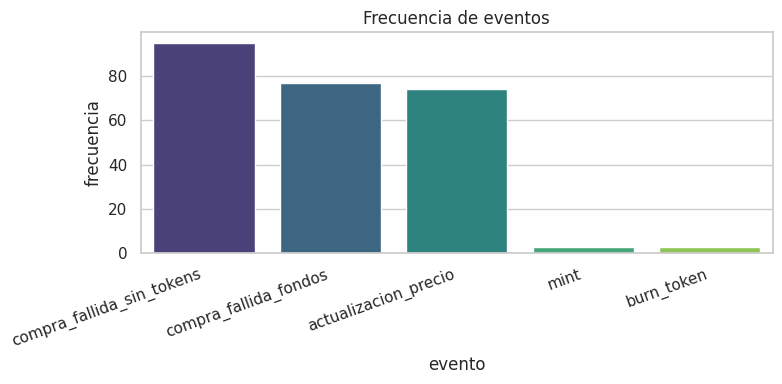

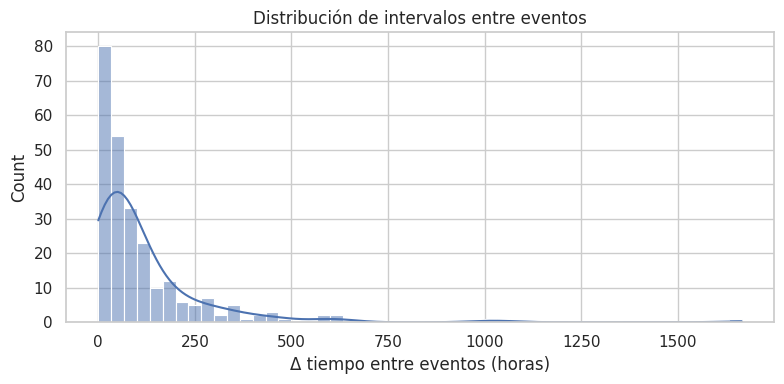

In [91]:
# === EDA compatible con 3 escenarios (ctrl3) o con eventos_all.csv ===
import os, json
from pathlib import Path
import numpy as np
import pandas as pd

DO_PLOTS_SINGLE = True
HEAD_N          = 5
TIME_UNIT       = globals().get("TIME_UNIT", "horas")
BASE_OUT        = Path("outputs")

def _eda_sencilla(df_eventos: pd.DataFrame, time_unit="horas",
                  save_dir: Path | None = None, do_plots: bool = False,
                  head_n: int = 5):
    resumen = {
        "n_filas":    int(df_eventos.shape[0]),
        "n_cols":     int(df_eventos.shape[1]),
        "t_min":      float(df_eventos["tiempo"].min()) if "tiempo" in df_eventos.columns and len(df_eventos) else np.nan,
        "t_max":      float(df_eventos["tiempo"].max()) if "tiempo" in df_eventos.columns and len(df_eventos) else np.nan,
        "duracion":   np.nan,
        "mint":       int((df_eventos["evento"].str.lower()=="mint").sum()) if "evento" in df_eventos.columns else 0,
        "compra_ok":  int((df_eventos["evento"].str.lower()=="compra_exitosa").sum()) if "evento" in df_eventos.columns else 0,
        "compra_fail_fondos": int((df_eventos["evento"].str.lower()=="compra_fallida_fondos").sum()) if "evento" in df_eventos.columns else 0,
        "compra_fail_sintok": int((df_eventos["evento"].str.lower()=="compra_fallida_sin_tokens").sum()) if "evento" in df_eventos.columns else 0,
        "burn":       int((df_eventos["evento"].str.lower()=="burn_token").sum()) if "evento" in df_eventos.columns else 0,
    }
    if not np.isnan(resumen["t_min"]) and not np.isnan(resumen["t_max"]):
        resumen["duracion"] = float(resumen["t_max"] - resumen["t_min"])

    print("▶ Forma:", df_eventos.shape, " | cols:", list(df_eventos.columns))
    if "tiempo" in df_eventos.columns:
        print(f"▶ Tiempo: min={resumen['t_min']:.2f}, max={resumen['t_max']:.2f} {time_unit}, duración={resumen['duracion']:.2f} {time_unit}")
    print("▶ Top filas:")
    print(df_eventos.head(head_n).to_string(index=False))

    if do_plots:
        import matplotlib.pyplot as plt, seaborn as sns
        sns.set(style="whitegrid")

        evt_counts = df_eventos["evento"].value_counts()
        if len(evt_counts):
            df_evt = evt_counts.rename_axis('evento').reset_index(name='frecuencia')
            plt.figure(figsize=(8,4))
            sns.barplot(data=df_evt, x="evento", y="frecuencia", hue="evento",
                        palette="viridis", dodge=False, legend=False)
            plt.xticks(rotation=20, ha="right")
            plt.title("Frecuencia de eventos")
            plt.tight_layout()
            if save_dir:
                save_dir.mkdir(parents=True, exist_ok=True)
                plt.savefig(save_dir / "freq_eventos.png", dpi=150)
            plt.show()

        if "tiempo" in df_eventos.columns:
            intervalos = df_eventos["tiempo"].diff().dropna()
            if len(intervalos):
                plt.figure(figsize=(8,4))
                sns.histplot(intervalos, bins=50, kde=True)
                plt.xlabel(f"Δ tiempo entre eventos ({time_unit})")
                plt.title("Distribución de intervalos entre eventos")
                plt.tight_layout()
                if save_dir:
                    plt.savefig(save_dir / "intervalos_eventos.png", dpi=150)
                plt.show()

    return resumen


# --- Nuevas rutas posibles ---
CTRL3_EV_PATH = BASE_OUT / "ctrl3" / "eventos_3esc.csv"
EV_ALL_PATH   = BASE_OUT / "eventos_all.csv"

# Elegí (opcional) qué escenario de control mostrar; si None, toma el primero
SELECT_CTRL_SCENARIO = None  # por ejemplo: "S2_gas_alto_precio_alto"

if CTRL3_EV_PATH.exists():
    df_all = pd.read_csv(CTRL3_EV_PATH)
    # Identificar columna de escenario
    scen_col = "escenario_control" if "escenario_control" in df_all.columns else (
               "scenario" if "scenario" in df_all.columns else None)
    assert scen_col is not None, f"El archivo {CTRL3_EV_PATH} no trae columna de escenario."

    escenarios = df_all[scen_col].astype(str).unique().tolist()
    if SELECT_CTRL_SCENARIO is None:
        chosen = escenarios[0]
    else:
        assert SELECT_CTRL_SCENARIO in escenarios, f"'{SELECT_CTRL_SCENARIO}' no está en {escenarios}"
        chosen = SELECT_CTRL_SCENARIO

    df_eventos = (df_all[df_all[scen_col] == chosen]
                  .drop(columns=[scen_col])
                  .reset_index(drop=True))
    print(f"📦 EDA (ctrl3): {len(df_all):,} filas — {len(escenarios)} escenarios. Mostrando: {chosen}")
    _ = _eda_sencilla(df_eventos, time_unit=TIME_UNIT, save_dir=Path("outputs/eda"), do_plots=DO_PLOTS_SINGLE, head_n=HEAD_N)

elif EV_ALL_PATH.exists():
    # Compatibilidad con el flujo anterior (eventos_all.csv)
    df_all = pd.read_csv(EV_ALL_PATH)
    print(f"📦 EDA agregado: {len(df_all):,} filas — {df_all['scenario'].nunique()} escenarios")
    scen0 = df_all["scenario"].iloc[0]
    df_eventos = df_all[df_all["scenario"] == scen0].drop(columns=["scenario"]).reset_index(drop=True)
    _ = _eda_sencilla(df_eventos, time_unit=TIME_UNIT, save_dir=Path("outputs/eda"), do_plots=DO_PLOTS_SINGLE, head_n=HEAD_N)

else:
    # Fallback: usar df_eventos si alguien lo dejó en memoria (p.ej. de un run single)
    if 'df_eventos' in globals():
        print("[EDA] Usando df_eventos en memoria (escenario único).")
        _ = _eda_sencilla(df_eventos, time_unit=TIME_UNIT, save_dir=Path("outputs/eda"), do_plots=DO_PLOTS_SINGLE, head_n=HEAD_N)
    else:
        raise FileNotFoundError(
            "No encuentro ni 'outputs/ctrl3/eventos_3esc.csv' ni 'outputs/eventos_all.csv', "
            "y no hay df_eventos en memoria. Corré el Driver de 3 escenarios primero."
        )


# 7. Variables de Resultados


=== RESULTADOS ===
CTS (Cantidad total de tokenizaciones solicitadas): 3
PTB (Porcentaje de tokens burneados): 100.00% (burn=3, emitidos=3)
PSC (Promedio de saldo compradores): 0.00
CTF (Cantidad de transferencias fallidas): 172


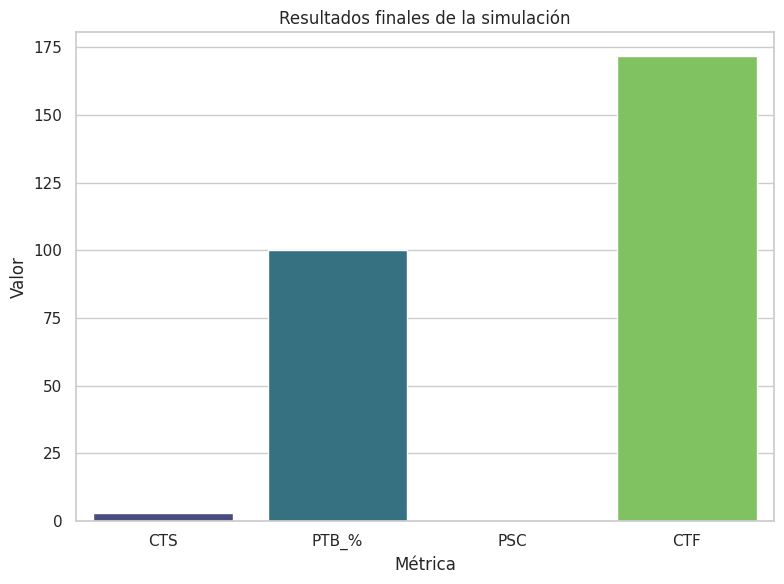

In [92]:
import os, numpy as np, pandas as pd
os.makedirs("outputs", exist_ok=True)

# Helper: derivar métricas desde df_eventos si no hay globals
def _metrics_from_df(df):
    d = df.copy()
    d["evento"] = d["evento"].astype(str).str.lower()

    cts = int((d["evento"] == "mint").sum())
    ctf = int(d["evento"].isin(["compra_fallida_fondos", "compra_fallida_sin_tokens"]).sum())
    emitidos = cts
    burneados = int((d["evento"] == "burn_token").sum())

    # PSC: promedio del 'extra' en compras exitosas (saldo remanente del comprador)
    comp = pd.to_numeric(d.loc[d["evento"] == "compra_exitosa", "extra"], errors="coerce").dropna()
    psc = float(comp.mean()) if len(comp) > 0 else 0.0

    return cts, ctf, emitidos, burneados, psc

# Caso A: escenario único (las globals existen)
if all(k in globals() for k in ("CTS", "CTF", "tokens_emitidos", "tokens_burneados")):
    CTS_final = int(CTS)
    CTF_final = int(CTF)
    tokens_emitidos_final = int(tokens_emitidos)
    tokens_burneados_final = int(tokens_burneados)

    # PSC: si no hay saldos_compradores global, derivar de df_eventos
    if "saldos_compradores" in globals() and len(saldos_compradores) > 0:
        PSC_final = float(np.mean(saldos_compradores))
    else:
        _, _, _, _, PSC_final = _metrics_from_df(df_eventos)

# Caso B: batch/unificado (no hay globals): derivar TODO desde df_eventos
else:
    CTS_final, CTF_final, tokens_emitidos_final, tokens_burneados_final, PSC_final = _metrics_from_df(df_eventos)

PTB_final_pct = (tokens_burneados_final / tokens_emitidos_final * 100.0) if tokens_emitidos_final > 0 else 0.0

# Tabla de métricas y export
res_df = pd.DataFrame([
    {"metrica": "CTS",   "valor": CTS_final},
    {"metrica": "PTB_%", "valor": PTB_final_pct},
    {"metrica": "PSC",   "valor": PSC_final},
    {"metrica": "CTF",   "valor": CTF_final},
])
res_df.to_csv("outputs/metricas.csv", index=False)

# Exportar conteo de eventos
evt_counts = df_eventos["evento"].value_counts().rename_axis("evento").reset_index(name="frecuencia")
evt_counts.to_csv("outputs/conteo_eventos.csv", index=False)

# Prints formateados
print("\n=== RESULTADOS ===")
print(f"CTS (Cantidad total de tokenizaciones solicitadas): {CTS_final}")
print(f"PTB (Porcentaje de tokens burneados): {PTB_final_pct:.2f}% "
      f"(burn={tokens_burneados_final}, emitidos={tokens_emitidos_final})")
print(f"PSC (Promedio de saldo compradores): {PSC_final:.2f}")
print(f"CTF (Cantidad de transferencias fallidas): {CTF_final}")

# Gráfico (una sola vez)
import matplotlib.pyplot as plt, seaborn as sns
plt.figure(figsize=(8,6))
sns.barplot(
    data=res_df,
    x="metrica", y="valor",
    hue="metrica", palette="viridis",
    dodge=False, legend=False
)
plt.xlabel("Métrica"); plt.ylabel("Valor"); plt.title("Resultados finales de la simulación")
plt.tight_layout(); plt.savefig("outputs/metricas_bar.png", dpi=150); plt.show()

# 8. Visualizaciones de Resultados

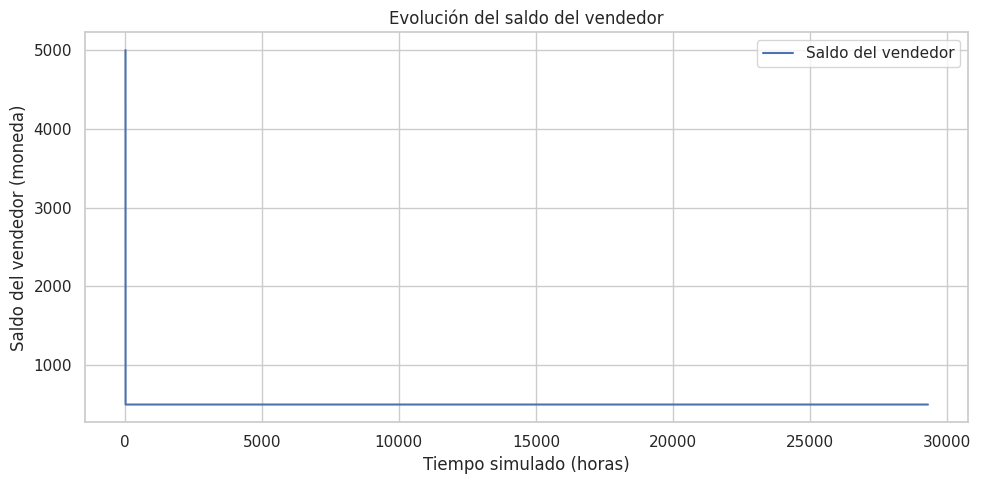

No hay compras exitosas, no se grafica la distribución de saldos de compradores.


In [93]:
import os
os.makedirs("outputs", exist_ok=True)

# Evolución del saldo del vendedor
plt.figure(figsize=(10,5))
sns.lineplot(data=df_eventos, x="tiempo", y="saldo_vendedor", label="Saldo del vendedor")
plt.xlabel(f"Tiempo simulado ({TIME_UNIT})")
plt.ylabel("Saldo del vendedor (moneda)")
plt.title("Evolución del saldo del vendedor")
plt.tight_layout()
plt.savefig("outputs/saldo_vendedor_tiempo.png", dpi=150)
plt.show()

# Distribución de saldos de compradores (solo si hubo compras)
if 'saldos_compradores' in globals() and len(saldos_compradores) > 0:
    plt.figure(figsize=(10,5))
    sns.histplot(saldos_compradores, bins=30, kde=True, color="green")
    plt.xlabel("Saldo de compradores (moneda)")
    plt.ylabel("Frecuencia")
    plt.title("Distribución de saldos de compradores post-compra")
    plt.tight_layout()
    plt.savefig("outputs/dist_saldos_compradores.png", dpi=150)
    plt.show()
else:
    print("No hay compras exitosas, no se grafica la distribución de saldos de compradores.")

# 9. Tokens en circulación vs tiempo

⏱ Tiempo simulado: 35.82 → 29293.18 horas
📏 Duración total: 29257.36 horas
📊 Registros: 252
🔢 Tokens en circulación (final): 0
📁 CSV: outputs/tokens_circulacion.csv
📁 Resumen guardado en: outputs/resumen_tiempo.csv


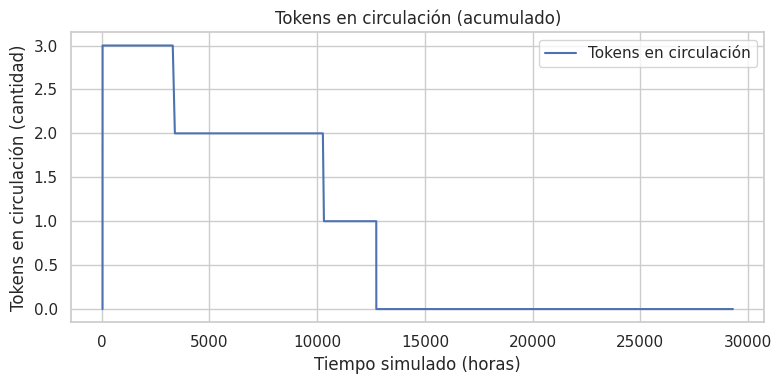

🖼️ PNG: outputs/tokens_circulacion.png


In [94]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def generar_tokens_y_resumen(
    df_eventos: pd.DataFrame,
    csv_path: str = "outputs/tokens_circulacion.csv",
    png_path: str = "outputs/tokens_circulacion.png",
    resumen_path: str = "outputs/resumen_tiempo.csv",
    overwrite_csv: bool = True,
    make_plot: bool = True,
):
    os.makedirs(os.path.dirname(csv_path), exist_ok=True)

    # Validaciones mínimas
    if "evento" not in df_eventos.columns or "tiempo" not in df_eventos.columns:
        raise ValueError("df_eventos debe contener las columnas 'evento' y 'tiempo'.")

    # Normalización básica
    df = df_eventos.copy()
    df["evento"] = df["evento"].astype(str).str.lower()
    df["tiempo"] = pd.to_numeric(df["tiempo"], errors="coerce")

    # Solo 'mint' (+1) y 'burn_token' (-1) cambian el supply
    delta = df["evento"].map({"mint": 1, "burn_token": -1}).fillna(0).astype(int)

    tok = pd.DataFrame(
        {"tiempo": df["tiempo"], "tokens_circulacion": delta.cumsum()}
    ).dropna(subset=["tiempo"]).sort_values("tiempo", ignore_index=True)

    # Exportar CSV idempotente
    if overwrite_csv or not os.path.exists(csv_path):
        tok.to_csv(csv_path, index=False)

    # Resumen numérico
    if len(tok) > 0:
        t_min = float(tok["tiempo"].min())
        t_max = float(tok["tiempo"].max())
        duracion = t_max - t_min
        n_reg = int(len(tok))
        final_supply = int(tok["tokens_circulacion"].iloc[-1])
    else:
        t_min = t_max = duracion = 0.0
        n_reg = final_supply = 0

    print(f"⏱ Tiempo simulado: {t_min:.2f} → {t_max:.2f} {TIME_UNIT}")
    print(f"📏 Duración total: {duracion:.2f} {TIME_UNIT}")
    print(f"📊 Registros: {n_reg}")
    print(f"🔢 Tokens en circulación (final): {final_supply}")
    print(f"📁 CSV: {csv_path}")

    # Exportar resumen a CSV
    resumen_df = pd.DataFrame([{
        "tiempo_min": t_min,
        "tiempo_max": t_max,
        "duracion": duracion,
        "n_registros": n_reg,
        "tokens_final": final_supply,
        "unidad_tiempo": TIME_UNIT,
    }])
    resumen_df.to_csv(resumen_path, index=False)
    print(f"📁 Resumen guardado en: {resumen_path}")

    # Gráfico opcional
    if make_plot and len(tok) > 0:
        plt.figure(figsize=(8,4))
        plt.plot(tok["tiempo"], tok["tokens_circulacion"], label="Tokens en circulación")
        plt.xlabel(f"Tiempo simulado ({TIME_UNIT})")
        plt.ylabel("Tokens en circulación (cantidad)")
        plt.title("Tokens en circulación (acumulado)")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(png_path, dpi=150)
        plt.show()
        print(f"🖼️ PNG: {png_path}")

    return tok, resumen_df

tok, resumen_tiempo = generar_tokens_y_resumen(
    df_eventos,
    csv_path="outputs/tokens_circulacion.csv",
    png_path="outputs/tokens_circulacion.png",
    resumen_path="outputs/resumen_tiempo.csv",
    overwrite_csv=True,    # False para NO reescribir el CSV existente
    make_plot=True         # False para no generar el PNG
)

# 10. Conclusiones

In [95]:
import os
import numpy as np
import pandas as pd
from textwrap import dedent

os.makedirs("outputs", exist_ok=True)

# ---- 1) Insumos: df_eventos, métricas, supply ----
# Métricas básicas (si no existen, las reconstruye)
CTS_val = int(CTS) if "CTS" in locals() else int((df_eventos["evento"].str.lower()=="mint").sum())
tokens_emitidos_val = int(tokens_emitidos) if "tokens_emitidos" in locals() else int((df_eventos["evento"].str.lower()=="mint").sum())
tokens_burneados_val = int(tokens_burneados) if "tokens_burneados" in locals() else int((df_eventos["evento"].str.lower()=="burn_token").sum())

if "PTB_final_pct" in locals():
    PTB_pct = float(PTB_final_pct)
else:
    PTB_pct = (tokens_burneados_val / tokens_emitidos_val * 100.0) if tokens_emitidos_val>0 else 0.0

PSC_val = float(PSC_final) if "PSC_final" in locals() else float(np.nan)
CTF_val = int(CTF) if "CTF" in locals() else int((df_eventos["evento"].str.contains("compra_fallida", case=False, na=False)).sum())

# Supply vs tiempo
tok_path = "outputs/tokens_circulacion.csv"
if os.path.exists(tok_path):
    tok = pd.read_csv(tok_path)
else:
    df = df_eventos.copy()
    df["evento"] = df["evento"].astype(str).str.lower()
    df["tiempo"] = pd.to_numeric(df["tiempo"], errors="coerce")
    delta = df["evento"].map({"mint": 1, "burn_token": -1}).fillna(0).astype(int)
    tok = pd.DataFrame({"tiempo": df["tiempo"], "tokens_circulacion": delta.cumsum()}).dropna(subset=["tiempo"]).sort_values("tiempo", ignore_index=True)

t_min = float(tok["tiempo"].min()) if len(tok)>0 else 0.0
t_max = float(tok["tiempo"].max()) if len(tok)>0 else 0.0
duracion = t_max - t_min
final_supply = int(tok["tokens_circulacion"].iloc[-1]) if len(tok)>0 else 0

# Tendencia del supply al final (slope en el último 30%)
if len(tok) >= 5:
    tail = tok.tail(max(5, int(len(tok)*0.3)))
    try:
        m, b = np.polyfit(tail["tiempo"], tail["tokens_circulacion"], 1)
    except Exception:
        m = 0.0
    if m > 0.02: tendencia_supply = "creciente"
    elif m < -0.02: tendencia_supply = "decreciente"
    else: tendencia_supply = "estable"
else:
    tendencia_supply = "indefinida"

# ---- 2) Tasas, fallas y stock ----
compras_mask = df_eventos["evento"].str.contains("compra", case=False, na=False)
total_compras = int(compras_mask.sum())
exitosas = int((df_eventos["evento"].str.lower()=="compra_exitosa").sum())
tasa_exito = (exitosas/total_compras*100.0) if total_compras>0 else np.nan

fall_fondos = int((df_eventos["evento"].str.lower()=="compra_fallida_fondos").sum())
fall_sintok = int((df_eventos["evento"].str.lower()=="compra_fallida_sin_tokens").sum())

# Stock sin vender al cierre: mint - burn - vendidas
mint_ids  = set(df_eventos.loc[df_eventos["evento"].str.lower()=="mint", "token"].dropna())
burn_ids  = set(df_eventos.loc[df_eventos["evento"].str.lower()=="burn_token", "token"].dropna())
sold_ids  = set(df_eventos.loc[df_eventos["evento"].str.lower()=="compra_exitosa", "token"].dropna())
stock_sin_vender = max(0, len(mint_ids - burn_ids - sold_ids))

# ---- 3) Intervalos TS / LLIN y mejor FDP si existiera ----
ts_series = tiempos_ts if 'tiempos_ts' in globals() else (
    df_eventos.loc[df_eventos["evento"].str.lower()=="mint", "tiempo"]
    .diff().dropna()
)
llin_series = tiempos_llin if 'tiempos_llin' in globals() else (
    df_eventos.loc[df_eventos["evento"].str.contains("compra", case=False, na=False), "tiempo"]
    .diff().dropna()
)

ts_mean   = float(ts_series.mean()) if len(ts_series)>0 else np.nan
llin_mean = float(llin_series.mean()) if len(llin_series)>0 else np.nan

def _best_name_from_dataset(best_dict):
    try:
        return list(best_dict.keys())[0] if best_dict else None
    except Exception:
        return None

# 1) Intentar con los fits del DATASET (bloque 2.1)
best_ts_name = _best_name_from_dataset(best_ts_dataset) if 'best_ts_dataset' in globals() else None
best_llin_name = _best_name_from_dataset(best_llin_dataset) if 'best_llin_dataset' in globals() else None

# 2) Si no están en memoria, leer de outputs/ajustes_fdp_dataset.csv
if (best_ts_name is None or best_llin_name is None) and os.path.exists("outputs/ajustes_fdp_dataset.csv"):
    try:
        aj = pd.read_csv("outputs/ajustes_fdp_dataset.csv")
        if best_ts_name is None:
            row = aj.loc[aj["variable"] == "TS"]
            if not row.empty: best_ts_name = str(row.iloc[0]["mejor_dist"])
        if best_llin_name is None:
            row = aj.loc[aj["variable"] == "LLIN"]
            if not row.empty: best_llin_name = str(row.iloc[0]["mejor_dist"])
    except Exception:
        pass

# Fallback final: leer archivos si existen
if best_ts_name is None or best_llin_name is None:
    for path in ["outputs/ajustes_fdp_sim.csv", "outputs/ajustes_fdp.csv"]:
        if os.path.exists(path):
            try:
                aj = pd.read_csv(path)
                if best_ts_name is None:
                    row = aj.loc[aj["variable"].str.contains("TS", na=False)]
                    if not row.empty: best_ts_name = str(row.iloc[0]["mejor_dist"])
                if best_llin_name is None:
                    row = aj.loc[aj["variable"].str.contains("LLIN", na=False)]
                    if not row.empty: best_llin_name = str(row.iloc[0]["mejor_dist"])
            except:
                pass

# ---- 4) Recomendaciones automáticas (simples) ----
recs = []

# Oferta vs demanda
if not np.isnan(ts_mean) and not np.isnan(llin_mean):
    if ts_mean > llin_mean:
        recs.append("La tokenización (TS) es más lenta que las llegadas (LLIN): podés **acelerar TS** (mayor emisión) o **aumentar `partes_de_prop`** para reducir faltantes.")
    else:
        recs.append("La tokenización (TS) es más rápida que las llegadas (LLIN): el supply se repone bien; revisá **estrategias de precio** si hay fallas por fondos.")

# Motivo principal de fallas
if fall_sintok > fall_fondos:
    recs.append("Las fallas por **falta de tokens** dominan: aumentar frecuencia de `mint` o **reducir `burn`** puede ayudar.")
elif fall_fondos > fall_sintok:
    recs.append("Las fallas por **fondos insuficientes** dominan: considerá **bajar `VALOR_TOKEN_MEDIA`** o modificar la distribución de saldos de compradores.")
else:
    if total_compras>0:
        recs.append("Las fallas se reparten parejo entre fondos y disponibilidad; podés actuar en ambos frentes: oferta y pricing.")

# PTB alto
if PTB_pct >= 20:
    recs.append("**PTB** elevado: revisar criterios de `burn_token` (P_BURN) para no erosionar el supply.")
elif PTB_pct <= 1 and tendencia_supply=="creciente":
    recs.append("**PTB** muy bajo y supply creciente: OK si es deseado; de lo contrario, introducir `burn` para controlar el circulante.")

# ---- 5) Componer conclusiones (Markdown) ----
ts_line   = f"- Tokenización (TS): media ≈ {ts_mean:.2f} {TIME_UNIT}" if not np.isnan(ts_mean) else "- Tokenización (TS): sin datos suficientes"
ts_line  += f"{' — mejor FDP: '+best_ts_name if best_ts_name else ''}"

llin_line = f"- Llegadas (LLIN): media ≈ {llin_mean:.2f} {TIME_UNIT}" if not np.isnan(llin_mean) else "- Llegadas (LLIN): sin datos suficientes"
llin_line+= f"{' — mejor FDP: '+best_llin_name if best_llin_name else ''}"

tasa_line = f"- Compras: {exitosas}/{total_compras} exitosas (**{tasa_exito:.1f}%**)" if total_compras>0 else "- Compras: sin eventos registrados"

conclusiones_md = dedent(f"""
## Conclusiones

**Horizonte & Supply**
- Horizonte simulado: {duracion:.2f} {TIME_UNIT} (de {t_min:.2f} a {t_max:.2f}).
- Supply en circulación al cierre: **{final_supply}** tokens — tendencia **{tendencia_supply}**.
- PTB (burn): **{PTB_pct:.2f}%** ({tokens_burneados_val}/{tokens_emitidos_val}).
- Stock sin vender al cierre: **{stock_sin_vender}** tokens.

**Ritmos del sistema**
{ts_line}
{llin_line}

**Demanda & Éxito de compras**
{tasa_line}
- Fallidas por fondos: {fall_fondos}
- Fallidas por falta de tokens: {fall_sintok}

**Recomendaciones rápidas**
- """ + "\n- ".join(recs) + """
""").strip()

print(conclusiones_md)

with open("outputs/conclusiones.md", "w", encoding="utf-8") as f:
    f.write(conclusiones_md + "\n")

print("📁 Conclusiones guardadas en: outputs/conclusiones.md")

## Conclusiones

**Horizonte & Supply**
- Horizonte simulado: 29257.36 horas (de 35.82 a 29293.18).
- Supply en circulación al cierre: **0** tokens — tendencia **estable**.
- PTB (burn): **100.00%** (3/3).
- Stock sin vender al cierre: **0** tokens.

**Ritmos del sistema**
- Tokenización (TS): media ≈ 1.28 horas — mejor FDP: foldnorm
- Llegadas (LLIN): media ≈ 171.10 horas — mejor FDP: beta

**Demanda & Éxito de compras**
- Compras: 0/172 exitosas (**0.0%**)
- Fallidas por fondos: 77
- Fallidas por falta de tokens: 95

**Recomendaciones rápidas**
- La tokenización (TS) es más rápida que las llegadas (LLIN): el supply se repone bien; revisá **estrategias de precio** si hay fallas por fondos.
- Las fallas por **falta de tokens** dominan: aumentar frecuencia de `mint` o **reducir `burn`** puede ayudar.
- **PTB** elevado: revisar criterios de `burn_token` (P_BURN) para no erosionar el supply.
📁 Conclusiones guardadas en: outputs/conclusiones.md


ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/commands/install.py", line 324, in run
    session = self.get_default_session(options)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/index_command.py", line 71, in get_default_session
    self._session = self.enter_context(self._build_session(options))
                                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/index_command.py", line 100, in _build_session
    session = 

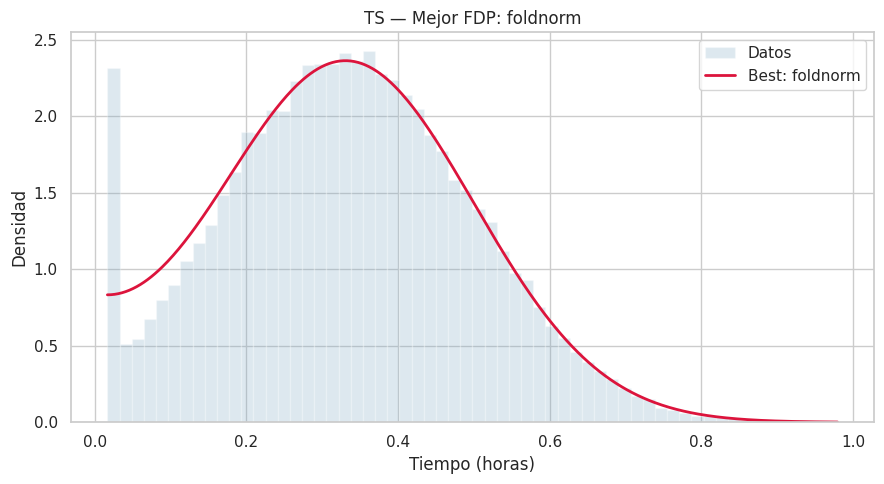

🖼️ outputs_fdp/ts_best_overlay.png


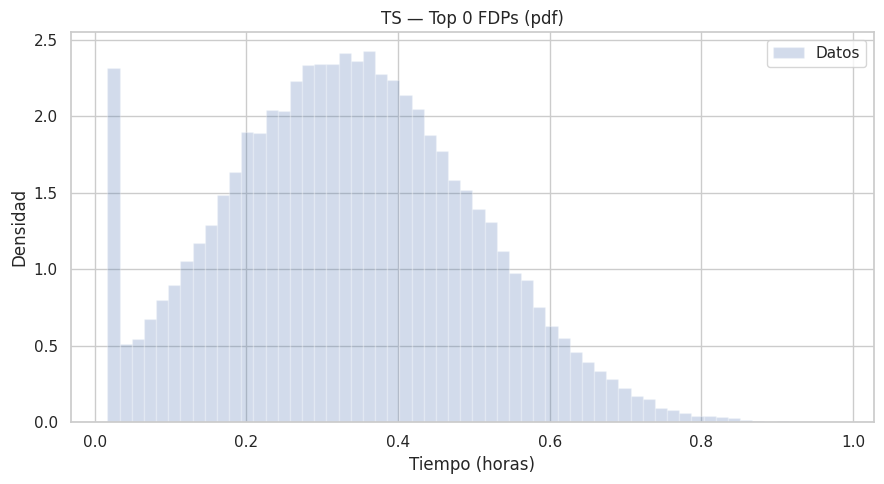

🖼️ outputs_fdp/ts_top0_overlay.png


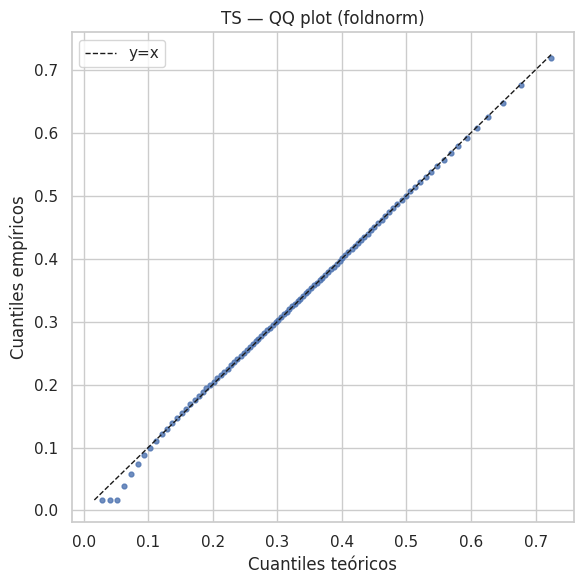

🖼️ outputs_fdp/ts_qq.png


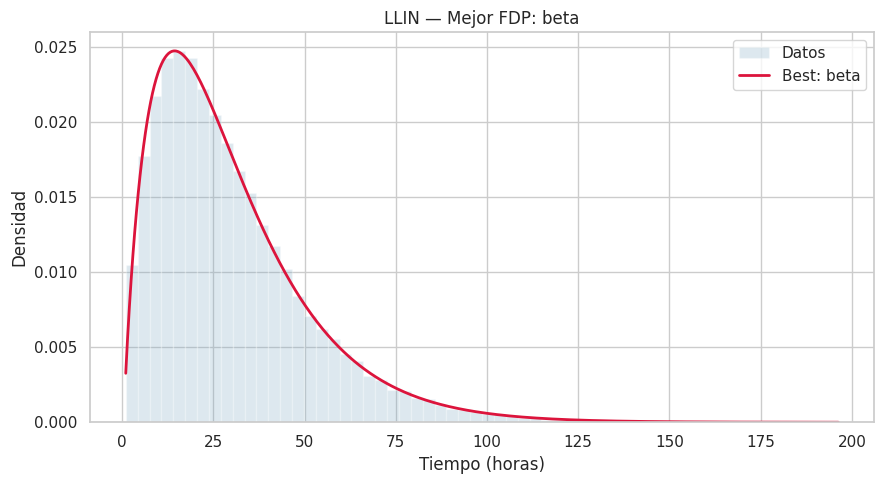

🖼️ outputs_fdp/llin_best_overlay.png


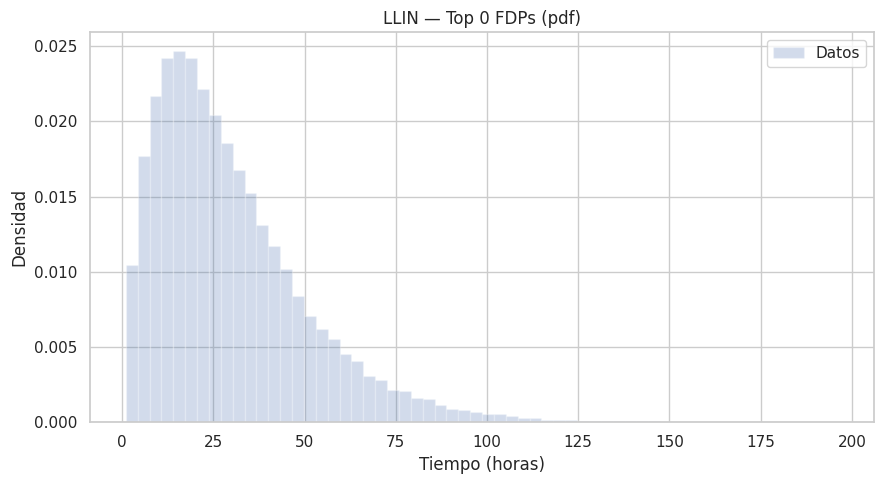

🖼️ outputs_fdp/llin_top0_overlay.png


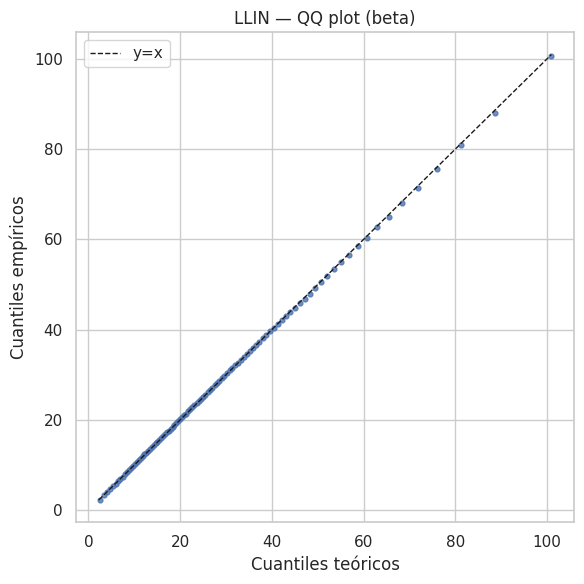

🖼️ outputs_fdp/llin_qq.png

=== Mejor FDP — TS ===
Dist: foldnorm
Params: {'c': 1.8628396677686365, 'loc': 0.016666665752324165, 'scale': 0.16887239768297052}
n=54000, mean=0.3354, std=0.1610, skew=0.2352, kurt=-0.3080
KS: D=0.0300, p=0.0000

=== Mejor FDP — LLIN ===
Dist: beta
Params: {'a': 1.8929395194400112, 'b': 648609.8369038888, 'loc': 0.4483324231763361, 'scale': 10124340.571899358}
n=54000, mean=29.9957, std=21.4758, skew=1.4536, kurt=3.1696
KS: D=0.0040, p=0.3390

📁 Archivos guardados en: /content/outputs_fdp
 - ajustes_fdp_dataset.json / .csv
 - TS_best_overlay.png / TS_topN_overlay.png / TS_qq.png
 - LLIN_best_overlay.png / LLIN_topN_overlay.png / LLIN_qq.png
🧩 Hardcode samplers guardado en: /content/outputs_fdp/hardcode_samplers.py


In [83]:
# =========================
# 0) Setup e instalaciones
# =========================
import sys, os, json
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB:
    %pip -q install --upgrade --no-input "numpy==1.26.4"
    %pip -q install --no-input "pandas>=1.5,<2.3" "matplotlib>=3.7,<3.9" seaborn "scipy>=1.10,<1.14" fitter==1.7.1

# =========================
# 1) Imports y configuración
# =========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from fitter import Fitter
from scipy import stats
from pathlib import Path

sns.set(style="whitegrid")
np.set_printoptions(precision=5, suppress=True)

# --- Config de columnas y unidades ---
TS_COL   = "mint_delay_min"                      # minutos → los convierto a horas
LLIN_COL = "potential_buyer_arrival_delay_time"  # ya viene en horas (configurable)
TS_TO_HOURS_DIV   = 60.0   # mins → horas
LLIN_TO_HOURS_DIV = 1.0    # horas → horas

# --- Dónde guardar outputs ---
BASE_OUT = Path("outputs_fdp")
BASE_OUT.mkdir(parents=True, exist_ok=True)

# --- Distribuciones a considerar (curado para acelerar) ---
DISTRO_LIST = [
    # básicas
    "expon", "norm", "lognorm", "gamma", "weibull_min", "weibull_max",
    # asimétricas útiles en colas
    "beta", "invgamma", "halfnorm", "foldnorm", "logistic"
]

TOPN = 5  # Top-N PDFs a superponer en el overlay (poner 0 para saltar plots overlay)

# =========================
# 2) Cargar CSV
# =========================
CSV_PATH = "/content/inputs/blockchain_real_state_data_2021_2022_full.csv"  # ← Opción A: poné la ruta como string, ej. "/content/inputs/tu_archivo.csv"

if CSV_PATH is None and IN_COLAB:
    from google.colab import files
    print("📥 Subí tu CSV con las columnas:", TS_COL, "y", LLIN_COL)
    up = files.upload()  # abre dialogo
    assert len(up) >= 1, "No subiste ningún archivo."
    CSV_PATH = list(up.keys())[0]

assert CSV_PATH is not None, "Definí CSV_PATH o usá el upload en Colab."
df = pd.read_csv(CSV_PATH)
print("✅ CSV cargado:", CSV_PATH, "— shape:", df.shape)
print("Cols:", list(df.columns))

# =========================
# 3) Helpers de ajuste y gráficos
# =========================
def _sanitize_series(x: pd.Series, div: float, name: str) -> pd.Series:
    s = pd.to_numeric(x, errors="coerce").dropna()
    s = s / float(div)
    s = s[np.isfinite(s) & (s > 0)]
    if len(s) < 3:
        print(f"⚠️ {name}: pocos datos (>0) tras limpieza: len={len(s)}")
    return s

def _rank_by_sse(f: Fitter, N: int) -> list:
    errs = getattr(f, "sumsquare_error", None) or getattr(f, "sum_square_error", None) or {}
    return [k for k, _ in sorted(errs.items(), key=lambda kv: kv[1])[:N]]

def _fit_series(series: pd.Series, var_label: str, out_dir: Path, topn: int = 5):
    s = series.values
    assert len(s) >= 3, f"{var_label}: se requieren al menos 3 datos positivos para ajustar."
    f = Fitter(s, distributions=DISTRO_LIST)
    f.fit()  # fit all in the list

    # Mejor por SSE
    best = f.get_best(method="sumsquare_error")  # dict {dist_name: {params}}
    if not best:
        raise RuntimeError(f"{var_label}: fitter no devolvió 'best'.")

    dist_name, params = list(best.items())[0]
    # Construir RV congelada
    rv = getattr(stats, dist_name)(**params)

    # Stats de la FDP y KS test
    mean, var = rv.mean(), rv.var()
    std = np.sqrt(var)
    # skew/kurt devuelven array; casteo a float
    skew = float(rv.stats(moments='s'))
    kurt = float(rv.stats(moments='k'))
    # KS (ojo con ties/continuidad; es orientativo)
    D, p = stats.kstest(s, rv.cdf)

    # Guardar resumen
    summary = {
        "variable": var_label,
        "best_dist": dist_name,
        "params": params,
        "n": int(len(s)),
        "mean_hat": float(mean),
        "std_hat": float(std),
        "skew_hat": float(skew),
        "kurt_hat": float(kurt),
        "ks_D": float(D),
        "ks_pvalue": float(p),
    }

    # --- Gráficos ---
    # Hist + PDF best
    xs = np.linspace(s.min(), s.max(), 400)
    plt.figure(figsize=(9,5))
    plt.hist(s, bins=60, density=True, alpha=0.25, color="#7aa6c2", label="Datos")
    try:
        plt.plot(xs, rv.pdf(xs), color="crimson", lw=2.0, label=f"Best: {dist_name}")
    except Exception as e:
        print(f"PDF plot falló para {dist_name}: {e}")
    plt.xlabel("Tiempo (horas)")
    plt.ylabel("Densidad")
    plt.title(f"{var_label} — Mejor FDP: {dist_name}")
    plt.legend()
    plt.tight_layout()
    fig1 = out_dir / f"{var_label.lower()}_best_overlay.png"
    plt.savefig(fig1, dpi=150); plt.show()
    print("🖼️", fig1)

    # Overlay Top-N
    if isinstance(topn, int) and topn > 0:
        names = _rank_by_sse(f, topn)
        plt.figure(figsize=(9,5))
        plt.hist(s, bins=60, density=True, alpha=0.25, label="Datos")
        for nm in names:
            pars = getattr(f, "fitted_param", {}).get(nm)
            if not pars:
                continue
            try:
                rvn = getattr(stats, nm)(**pars)
                plt.plot(xs, rvn.pdf(xs), lw=1.5, label=nm)
            except Exception:
                continue
        plt.xlabel("Tiempo (horas)")
        plt.ylabel("Densidad")
        plt.title(f"{var_label} — Top {len(names)} FDPs (pdf)")
        plt.legend()
        plt.tight_layout()
        fig2 = out_dir / f"{var_label.lower()}_top{len(names)}_overlay.png"
        plt.savefig(fig2, dpi=150); plt.show()
        print("🖼️", fig2)

    # QQ plot (cuantiles teóricos vs observados)
    probs = np.linspace(0.01, 0.99, 99)
    q_theo = rv.ppf(probs)
    q_emp  = np.quantile(s, probs)
    plt.figure(figsize=(6,6))
    plt.scatter(q_theo, q_emp, s=12, alpha=0.8)
    lims = [min(q_theo.min(), q_emp.min()), max(q_theo.max(), q_emp.max())]
    plt.plot(lims, lims, 'k--', lw=1, label="y=x")
    plt.xlabel("Cuantiles teóricos")
    plt.ylabel("Cuantiles empíricos")
    plt.title(f"{var_label} — QQ plot ({dist_name})")
    plt.legend()
    plt.tight_layout()
    fig3 = out_dir / f"{var_label.lower()}_qq.png"
    plt.savefig(fig3, dpi=150); plt.show()
    print("🖼️", fig3)

    # Devolver objetos clave y el Fitter por si querés más info
    return summary, f

def _export_best_json_csv(ts_summary: dict, llin_summary: dict, out_dir: Path):
    rows = []
    for s in [ts_summary, llin_summary]:
        row = {
            "variable": s["variable"],
            "mejor_dist": s["best_dist"],
            "params_json": json.dumps(s["params"]),
            "n": s["n"],
            "mean_hat": s["mean_hat"],
            "std_hat": s["std_hat"],
            "skew_hat": s["skew_hat"],
            "kurt_hat": s["kurt_hat"],
            "ks_D": s["ks_D"],
            "ks_pvalue": s["ks_pvalue"],
        }
        rows.append(row)
    pd.DataFrame(rows).to_csv(out_dir / "ajustes_fdp_dataset.csv", index=False)
    with open(out_dir / "ajustes_fdp_dataset.json", "w", encoding="utf-8") as f:
        json.dump(rows, f, ensure_ascii=False, indent=2)

# =========================
# 4) Preparar series (horas)
# =========================
ts_hours   = _sanitize_series(df[TS_COL],   div=TS_TO_HOURS_DIV,   name="TS")
llin_hours = _sanitize_series(df[LLIN_COL], div=LLIN_TO_HOURS_DIV, name="LLIN")

print(f"TS (horas): n={len(ts_hours)}, min={ts_hours.min() if len(ts_hours) else np.nan:.4f}, max={ts_hours.max() if len(ts_hours) else np.nan:.4f}")
print(f"LLIN (horas): n={len(llin_hours)}, min={llin_hours.min() if len(llin_hours) else np.nan:.4f}, max={llin_hours.max() if len(llin_hours) else np.nan:.4f}")

assert len(ts_hours)   >= 3, "TS: se necesitan >=3 datos positivos."
assert len(llin_hours) >= 3, "LLIN: se necesitan >=3 datos positivos."

# =========================
# 5) Ajustar, mostrar mejores y graficar
# =========================
ts_summary, f_ts     = _fit_series(ts_hours,   var_label="TS",   out_dir=BASE_OUT, topn=TOPN)
llin_summary, f_llin = _fit_series(llin_hours, var_label="LLIN", out_dir=BASE_OUT, topn=TOPN)

print("\n=== Mejor FDP — TS ===")
print("Dist:", ts_summary["best_dist"])
print("Params:", ts_summary["params"])
print(f"n={ts_summary['n']}, mean={ts_summary['mean_hat']:.4f}, std={ts_summary['std_hat']:.4f}, "
      f"skew={ts_summary['skew_hat']:.4f}, kurt={ts_summary['kurt_hat']:.4f}")
print(f"KS: D={ts_summary['ks_D']:.4f}, p={ts_summary['ks_pvalue']:.4f}")

print("\n=== Mejor FDP — LLIN ===")
print("Dist:", llin_summary["best_dist"])
print("Params:", llin_summary["params"])
print(f"n={llin_summary['n']}, mean={llin_summary['mean_hat']:.4f}, std={llin_summary['std_hat']:.4f}, "
      f"skew={llin_summary['skew_hat']:.4f}, kurt={llin_summary['kurt_hat']:.4f}")
print(f"KS: D={llin_summary['ks_D']:.4f}, p={llin_summary['ks_pvalue']:.4f}")

# Exportar a JSON/CSV (para reusar en otra notebook)
_export_best_json_csv(ts_summary, llin_summary, BASE_OUT)

print("\n📁 Archivos guardados en:", BASE_OUT.resolve())
print(" - ajustes_fdp_dataset.json / .csv")
print(" - TS_best_overlay.png / TS_topN_overlay.png / TS_qq.png")
print(" - LLIN_best_overlay.png / LLIN_topN_overlay.png / LLIN_qq.png")

# =========================
# 6) (Opcional) Bloque “hardcode” para tu otra notebook
# =========================
def emit_hardcode_block(ts_summary, llin_summary, out_dir: Path):
    ts_name = ts_summary["best_dist"]; llin_name = llin_summary["best_dist"]
    ts_par  = ts_summary["params"];    llin_par  = llin_summary["params"]
    code = f'''# === HARDCODE de samplers (copiar/pegar en tu otra notebook) ===
from scipy import stats

TS_PARAMS   = {json.dumps(ts_par)}
LLIN_PARAMS = {json.dumps(llin_par)}

gen_TS_dataset   = (lambda rv=stats.{ts_name}(**TS_PARAMS):   (lambda: float(rv.rvs(1)[0])))()
gen_LLIN_dataset = (lambda rv=stats.{llin_name}(**LLIN_PARAMS): (lambda: float(rv.rvs(1)[0])))()

globals()['gen_TS_dataset']    = gen_TS_dataset
globals()['gen_LLIN_dataset']  = gen_LLIN_dataset
globals()['best_ts_dataset']   = {{"{ts_name}": TS_PARAMS}}
globals()['best_llin_dataset'] = {{"{llin_name}": LLIN_PARAMS}}
'''
    path = out_dir / "hardcode_samplers.py"
    with open(path, "w", encoding="utf-8") as f:
        f.write(code)
    print("🧩 Hardcode samplers guardado en:", path.resolve())

emit_hardcode_block(ts_summary, llin_summary, BASE_OUT)
